In [1]:
from pythtb import Lattice, TBModel, Mesh, WFArray, Wannier
from axion import axion_angle_3form, fin_diff
from pythtb.utils import levi_civita, finite_diff_coeffs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
lat_vecs = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
orb_vecs = [[0, 0, 0], [0.25, 0.25, 0.25]]
lat = Lattice(lat_vecs, orb_vecs, periodic_dirs=[0, 1, 2])

fkm_model = TBModel(lattice=lat, spinful=True)

t = 1.0
soc = 1/4
m = 1/2

fkm_model.set_onsite(
    lambda beta: [0, m*np.sin(beta), m*np.sin(beta), m*np.sin(beta)],
    ind_i=0,
)
fkm_model.set_onsite(
    lambda beta: [0, -m*np.sin(beta), -m*np.sin(beta), -m*np.sin(beta)],
    ind_i=1,
)

# spin-independent first-neighbor hops
for lvec in ([-1, 0, 0], [0, -1, 0], [0, 0, -1]):
    fkm_model.set_hop(t, 0, 1, lvec)

fkm_model.set_hop(
    lambda beta: 3 * t + m * np.cos(beta), 
    0, 1, [0, 0, 0], mode="set")

# spin-dependent second-neighbor hops
lvec_list = ([1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, 1, 0], [0, -1, 1], [1, 0, -1])
dir_list = ([0, 1, -1], [-1, 0, 1], [1, -1, 0], [1, 1, 0], [0, 1, 1], [1, 0, 1])
for j in range(6):
    spin = np.array([0.0] + dir_list[j])
    fkm_model.set_hop(1j * soc * spin, 0, 0, lvec_list[j])
    fkm_model.set_hop(-1j * soc * spin, 1, 1, lvec_list[j])

print(fkm_model)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 3
k-space dimension           = 3
periodic directions         = [0, 1, 2]
spinful                     = True
number of spin components   = 2
number of electronic states = 4
number of orbitals          = 2

Lattice vectors (Cartesian):
  # 0 ===> [ 0.000,  1.000,  1.000]
  # 1 ===> [ 1.000,  0.000,  1.000]
  # 2 ===> [ 1.000,  1.000,  0.000]
Volume of unit cell (Cartesian) = 2.000 [A^d]

Reciprocal lattice vectors (Cartesian):
  # 0 ===> [-3.142,  3.142,  3.142]
  # 1 ===> [ 3.142, -3.142,  3.142]
  # 2 ===> [ 3.142,  3.142, -3.142]
Volume of reciprocal unit cell = 124.025 [A^-d]

Orbital vectors (Cartesian):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.500,  0.500,  0.500]

Orbital vectors (fractional):
  # 0 ===> [ 0.000,  0.000,  0.000]
  # 1 ===> [ 0.250,  0.250,  0.250]
----------------------------------------
Site energies:


In [3]:
### Adiabatic parameters
# k space
nks = 30, 30, 30

# lambda space
n_beta = 51
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=True) 

########### Useful model information ###########
recip_lat_vecs = fkm_model.recip_lat_vecs  # Reciprocal lattice vectors (Cartesian)
n_spin = fkm_model.nspin   # Number of spins
n_orb = fkm_model.norb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

n_param = nks + (n_beta,)    # Number of points in 4d mesh
dim_k = fkm_model.dim_k      # Number of k-space dimensions (3)
dim_lam = 1                  # Number of adiabatic dimensions (1)
dim_total = dim_k + dim_lam  # Total number of dimensions (4)

print(f"Number of orbs: {n_orb}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)
print("(nks, nbeta):", n_param)
print("Total number of parameter points:", np.prod(n_param))

Number of orbs: 2
Number of spins: 2
Number of states: 4
Number of occupied bands: 2
(nks, nbeta): (30, 30, 30, 51)
Total number of parameter points: 1377000


In [4]:
betas_4curv, thetas_4curv, c2 = fkm_model.axion_angle(
    nks=nks, 
    param_periods={'beta': 2*np.pi},
    return_second_chern=True, 
    use_tensorflow=True,
    diff_order=8,
    beta=betas
)

In [5]:
mesh = Mesh(dim_k=3, axis_types=["k", "k", "k"])
mesh.build_grid(shape=nks)
dks = [1/nk for nk in nks]

In [6]:
def find_diff_axion(model, tf_list):

    print("Solving model...")
   
    wfa = WFArray(model.lattice, mesh, spinful=model.spinful)
    wfa.solve_model(model, use_tensorflow=True)

    print("Getting smooth gauge...")
    wannier = Wannier(wfa)
    wannier.project(tf_list)
    tilde_wfs = wannier.tilde_states

    print("Computing Berry connection in smooth gauge...")
    A_tilde = tilde_wfs.berry_connection()
    parx_A = fin_diff(A_tilde, mu=1, dk_mu=dks[0], order_eps=1, mode='forward')
    pary_A = fin_diff(A_tilde, mu=2, dk_mu=dks[1], order_eps=1, mode='forward')
    parz_A = fin_diff(A_tilde, mu=3, dk_mu=dks[2], order_eps=1, mode='forward')
    dmu_Atilde = np.array([parx_A, pary_A, parz_A])

    print("Computing theta from 3-form connection...")
    epsilon = levi_civita(3, 3)
    A_til_tf = tf.convert_to_tensor(A_tilde, tf.complex64)
    AdA = tf.einsum('i...ab,jk...ba->ijk...', A_til_tf, dmu_Atilde)
    AAA = tf.einsum('i...ab,j...bc,k...ca->ijk...', A_til_tf, A_til_tf, A_til_tf)
    integrand = tf.einsum("ijk, ijk... -> ...", epsilon, AdA - (2j/3) * AAA).numpy()
    theta_fd = -(4*np.pi)**(-1) * np.sum(integrand) * np.prod(dks)

    return theta_fd
    

In [7]:
betas[0] - betas[1]

np.float64(-0.12566370614359174)

In [23]:
thetas_3form_curv = np.zeros((betas.shape[0]))
thetas_3form_conn = np.zeros((betas.shape[0]))
thetas_3form_fd = np.zeros((betas.shape[0]))

window = 0.6

for idx, beta in enumerate(betas):
    print(f"Computing theta for beta index {idx} / {betas.shape[0]-1}")

    print("Defining model...")
    model = fkm_model.copy()
    model.set_parameters({"beta": beta})

    # trial wavefunctions of form (orbital, spin, amp)
    # buffer zone to avoid singularity at beta = pi
    # tf_list = [ 
    #     [(0, 0, -1), (0, 1, 1)], 
    #     [(1, 0, 1), (1, 1, 1)]
    #     ]
    if abs(beta - np.pi) < window:
        # breaks TRS in gauge to avoid topological obstruction
        tf_list = [ 
            [(0, 0, -1), (0, 1, 1)], 
            [(1, 0, 1), (1, 1, 1)]
            ]
    else:
        tf_list = [[(0, 0, 1), (1, 0, -1)], [(0, 1, 1), (1, 1, -1)]]

    print("Getting axion angle via Sylvester 3-form...")
    theta, theta2 = axion_angle_3form(
        model, tf_list, nks=nks, return_both=True, order_fd=11,
        use_tf_speedup=True
        )
    thetas_3form_curv[idx] = theta
    thetas_3form_conn[idx] = theta2

    theta_fd = find_diff_axion(model, tf_list)
    thetas_3form_fd[idx] = theta_fd

    print(f"idx: {idx}, beta: {beta}, theta: {theta.real}, theta_fd: {theta_fd.real}")
    print("-----")

Computing theta for beta index 0 / 50
Defining model...
Getting axion angle via Sylvester 3-form...
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
idx: 0, beta: 0.0, theta: 4.2688679968705413e-10, theta_fd: 5.466597610049778e-05
-----
Computing theta for beta index 1 / 50
Defining model...
Getting axion angle via Sylvester 3-form...


/var/folders/nn/m4t491h92ss8vwl56z761h6c0000gn/T/ipykernel_34295/1540792604.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  thetas_3form_fd[idx] = theta_fd


Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
idx: 1, beta: 0.12566370614359174, theta: 0.1044192581176758, theta_fd: 0.09428016493055555
-----
Computing theta for beta index 2 / 50
Defining model...
Getting axion angle via Sylvester 3-form...
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
idx: 2, beta: 0.25132741228718347, theta: 0.19971360778808597, theta_fd: 0.1810373806423611
-----
Computing theta for beta index 3 / 50
Defining model...
Getting axion angle via Sylvester 3-form...
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
idx: 3, beta: 0.3769911184307752, theta: 0.2803590393066407, theta_fd: 0.25551444950810187
-----
Computing theta for beta index 4 / 50
Defining model...
Getting axion angle via Sylvester 3-form...
Solving model...
Get

In [24]:
thetas_proj_conn = np.unwrap(thetas_3form_conn)
thetas_proj_curv = np.unwrap(thetas_3form_curv)
thetas_fd = np.unwrap(thetas_3form_fd)

In [25]:
mask = abs(betas - np.pi) < window

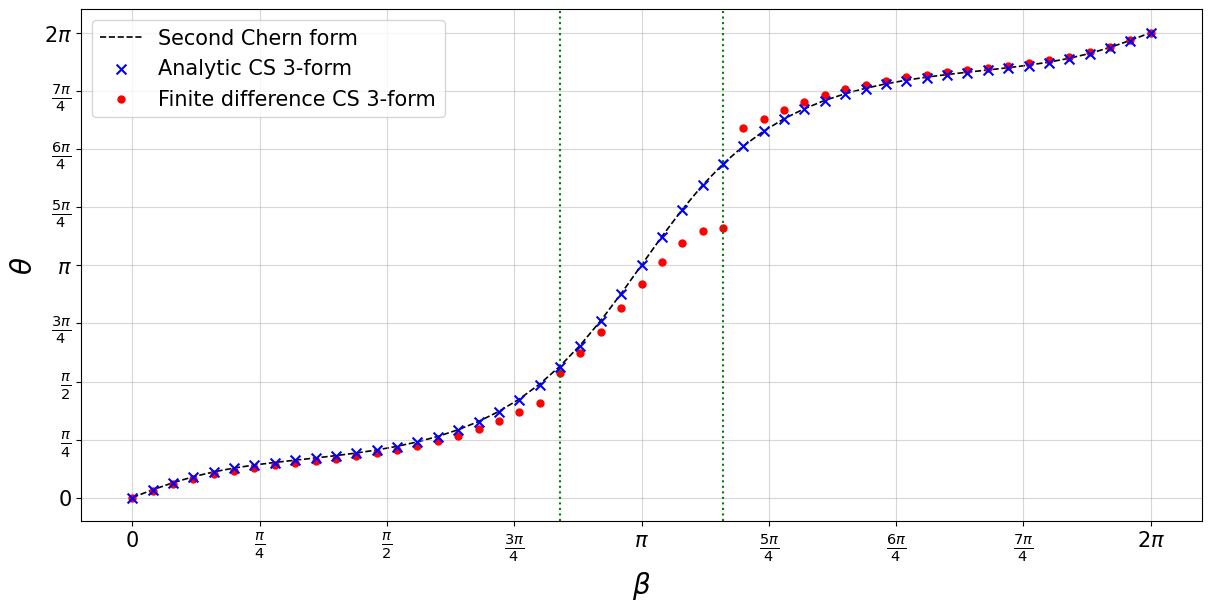

In [29]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)  # PRB single-column friendly

ax.plot(
    betas, thetas_4curv.real, 
    lw=1.2, zorder=1, c='k', ls='--',
    label=r"Second Chern form"
    )  


ax.scatter(
    betas, thetas_proj_curv, 
    s=50, c='b', zorder=3, marker='x',
    label=r"Analytic CS 3-form"
    )

ax.scatter(
    betas, thetas_fd, 
    s=25, c='r', zorder=2, marker='o',
    label=r"Finite difference CS 3-form"
    )

# ax.scatter(
#     betas, thetas_proj_conn,
#     s=15, c='r', zorder=2, marker='o', 
#     label="Chern-Simons 3-form from connection"
#     )

ax.set_xlabel(r"$\beta$", size=20)
ax.set_ylabel(r"$\theta$", size=20)

ax.axvline(betas[mask][0], ls=':', c='g')
ax.axvline(betas[mask][-1], ls=':', c='g')

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, size=15)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels, size=15)

# ax.tick_params(direction="out", length=4, width=0.9)
# ax.minorticks_on()
# ax.grid(True, which="major", alpha=0.8, linewidth=1)
# ax.grid(True, which="minor", alpha=1, linewidth=0.5)

ax.grid(alpha=0.5)
ax.legend(loc='upper left', prop={'size': 15})
# ax.set_title(fr"$N_k = ${nks}, $C_2 = {c2:.4f}$", size=15)
plt.savefig("fkm_axion_angle_comparison.png", dpi=600, bbox_inches="tight")
plt.show()

In [12]:
nkxs = [10, 20, 30, 40, 50, 75, 100, 150]

thetas_beta_pi_curv = np.zeros(len(nkxs))
thetas_beta_pi_conn = np.zeros(len(nkxs))
thetas_beta_pi_4curv = np.zeros(len(nkxs))
thetas_beta_pi_fd = np.zeros(len(nkxs))

beta = np.pi

for idx, nkx in enumerate(nkxs):
    nks = nkx, nkx, nkx
    print(f"Processing nks = {nks} -> Nk = {nkx**3}")

    # 4-curvature
    betas_kubo, thetas_kubo, c2 = fkm_model.axion_angle(
    nks=nks, 
    param_periods={'beta': 2*np.pi},
    return_second_chern=True, 
    use_tensorflow=True,
    diff_order=1,
    beta=betas
    )

    thetas_beta_pi_4curv[idx] = thetas_kubo[np.abs(betas - np.pi).argmin()]

    # 3-form
    model = fkm_model.copy()
    model.set_parameters({"beta": beta})

    # trial wavefunctions of form (orbital, spin, amp)
    # breaks TRS in gauge to avoid topological obstruction
    tf_list = [ 
        [(0, 0, -1), (0, 1, 1)], 
        [(1, 0, 1), (1, 1, 1)]
        ]
    
    theta_curv, theta_conn = axion_angle_3form(model, tf_list, nks=nks, return_both=True, order_fd=21, use_tf_speedup=True)
    thetas_fd = find_diff_axion(model, tf_list)

    thetas_beta_pi_curv[idx] = theta_curv.real
    thetas_beta_pi_conn[idx] = theta_conn.real
    thetas_beta_pi_fd[idx] = thetas_fd.real

Processing nks = (10, 10, 10) -> Nk = 1000
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
Processing nks = (20, 20, 20) -> Nk = 8000
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
Processing nks = (30, 30, 30) -> Nk = 27000
Solving model...
Getting smooth gauge...
Computing Berry connection in smooth gauge...
Computing theta from 3-form connection...
Processing nks = (40, 40, 40) -> Nk = 64000


KeyboardInterrupt: 

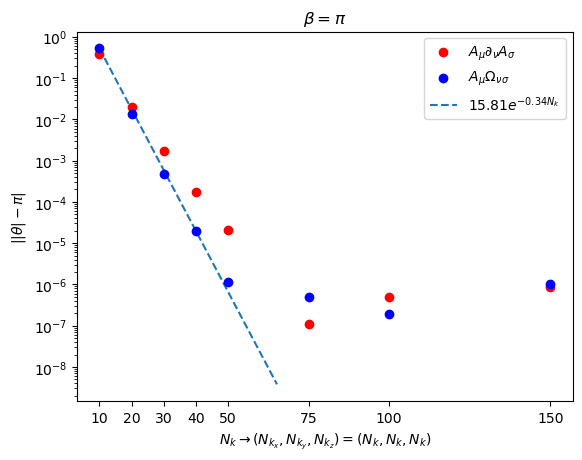

In [ ]:
fig, ax = plt.subplots()

ax.scatter(nkxs[:], abs(delta_theta_conn[:]), c='r', label=r'$A_{\mu} \partial_{\nu} A_{\sigma}$')
ax.scatter(nkxs[:], abs(delta_theta_curv[:]), c='b', label=r'$A_{\mu}\Omega_{\nu\sigma}$')

# error
N = np.linspace(nkxs[0], nkxs[-1], 100)
a = 0.34
C = abs(delta_theta_curv[0])*np.exp(a*N[0])
fit = C*np.exp(-a * N)
ax.plot(N[:40], fit[:40], ls='--', label=rf'${C:.2f}e^{{-{a} N_k}}$', zorder=0)

ax.set_xlabel(r'$N_k \rightarrow (N_{k_x}, N_{k_y}, N_{k_z}) = (N_{k}, N_{k}, N_{k})$')
ax.set_ylabel(r'$| |\theta| - \pi |$')
ax.set_title(r"$\beta = \pi$")
ax.set_xticks(nkxs)

plt.yscale('log') 
plt.legend()